#EXPLORATORY DATA ANALYSIS
This project is possible thanks to MySkill E-Learning: Python for Data Analyst and the tutors Muhammad Ihza & Ivan Adhitama Christanto.

# Pendahuluan - Import Library & Dataframe

In [50]:
#import Library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [7]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1J8h9oVngI164ao6C2y46JhZK1Zjfh8Zc/edit#gid=1839236009'
sheet_url_trf = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=') # convert editable spreadsheet csv
print(sheet_url_trf)

df = pd.read_csv(sheet_url_trf) 
df.info()
df.head() 

https://docs.google.com/spreadsheets/d/1J8h9oVngI164ao6C2y46JhZK1Zjfh8Zc/export?format=csv&gid=1839236009
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


#Bagian 1 - DATA CLEANSING

In [57]:
# mengubah tipe data order_date dari object ke datetime
df_clean = df.copy()
df_clean['order_date'] = pd.to_datetime(df_clean['order_date']) # function pd.to_datetime untuk ubah text jadi tanggal

print(df_clean.info()) #mengetahui tipe data dari setiap kolom
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      461773 non-null  object        
 1   product_code  461773 non-null  object        
 2   product_name  459055 non-null  object        
 3   quantity      461773 non-null  int64         
 4   order_date    461773 non-null  datetime64[ns]
 5   price         461773 non-null  float64       
 6   customer_id   360853 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 24.7+ MB
None


,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [58]:
# membuat kolom date
df_clean['date'] = pd.to_datetime(df_clean['order_date']).dt.date

# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]

# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()

# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]

# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')

# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()

# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]

# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)
df_clean = df_clean.reset_index(drop=True)
df_clean

# menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

<ipython-input-58-92bc50787607>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['product_name'] = df_clean['product_name'].str.lower()
<ipython-input-58-92bc50787607>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['amount'] = df_clean['quantity'] * df_clean['price']


,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,cancelled,4.25
1,493413,21724,panda and bunnies sticker sheet,1,2010-01-04 09:54:00,0.85,nan,2010-01-04,delivered,0.85
2,493413,84578,elephant toy with blue t-shirt,1,2010-01-04 09:54:00,3.75,nan,2010-01-04,delivered,3.75
3,493413,21723,alphabet hearts sticker sheet,1,2010-01-04 09:54:00,0.85,nan,2010-01-04,delivered,0.85
4,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,delivered,91.80
...,...,...,...,...,...,...,...,...,...,...
455491,539991,21618,4 wildflower botanical candles,1,2010-12-23 16:49:00,1.25,nan,2010-12-23,delivered,1.25
455492,539991,72741,grand chocolatecandle,4,2010-12-23 16:49:00,1.45,nan,2010-12-23,delivered,5.80
455493,539992,21470,flower vine raffia food cover,1,2010-12-23 17:41:00,3.75,nan,2010-12-23,delivered,3.75
455494,539992,22258,felt farm animal rabbit,1,2010-12-23 17:41:00,1.25,nan,2010-12-23,delivered,1.25


In [59]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455496 entries, 0 to 455495
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      455496 non-null  object        
 1   product_code  455496 non-null  object        
 2   product_name  455496 non-null  object        
 3   quantity      455496 non-null  int64         
 4   order_date    455496 non-null  datetime64[ns]
 5   price         455496 non-null  float64       
 6   customer_id   455496 non-null  object        
 7   date          455496 non-null  object        
 8   order_status  455496 non-null  object        
 9   amount        455496 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 34.8+ MB


#Bagian 2 - DATA UNDERSTANDING

##2.1 Mengetahui banyak baris/record dan kolom/variabel/feature

In [10]:
df_clean.shape

(458246, 9)

##2.2 Mengetahui nilai unik dari kolom/variabel kategorikal

###2.2.1 tanpa informasi frekuensi dari masing-masing nilai unik

In [12]:
df_clean['order_status'].unique()

array(['cancelled', 'delivered'], dtype=object)

###2.2.2 dengan informasi frekuensi dari masing-masing nilai unik

In [13]:
df_clean['order_status'].value_counts()

delivered    449996
cancelled      8250
Name: order_status, dtype: int64

#Bagian 3 - Menghitung descriptive statistics dari DataFrame

##3.1 Mengetahui statistik dari distribusi data numerik di keseluruhan kolom pada DataFrame sekaligus secara kuantitatif

In [14]:
df_clean.describe()

,quantity,price,amount
count,458246.000000,458246.000000,458246.000000
mean,10.004764,4.903037,19.512293
std,61.180755,99.536887,118.566258
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.100000,9.300000
75%,10.000000,4.210000,17.000000
max,10000.000000,25111.090000,25111.090000


##3.2 Mengetahui statistik tertentu secara individual

In [17]:
# frekuensi (frequency) - tak unik
df_clean['order_id'].count()

458246

In [18]:
# frekuensi (frequency) - unik
df_clean['order_id'].nunique()

22244

In [19]:
# jumlahan (sum)
df_clean['quantity'].sum()

4584643

In [20]:
# jumlahan (sum) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].sum()

166722

In [21]:
# rata-rata (mean)
df_clean['quantity'].mean()

10.004763816814549

In [22]:
# rata-rata (mean) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].mean()

9.657205746061168

In [23]:
# median
df_clean['quantity'].median()

3.0

In [24]:
# median subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].median()

3.0

In [25]:
# modus (mode)
df_clean['quantity'].mode()[0]

1

In [26]:
# modus (mode) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].mode()[0]

1

In [27]:
# jangkauan (range)
df_clean['quantity'].max() - df_clean['quantity'].min()

9999

In [28]:
# jangkauan (range) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].max() - df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].min()

4607

In [29]:
# simpangan baku (standard deviation)
df_clean['quantity'].std()

61.180755115984596

In [30]:
# simpangan baku (standard deviation) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].std()

44.822549676317

In [31]:
# varians (variance)
df_clean['quantity'].var()

3743.084796562075

In [32]:
df_clean['quantity'].std()**2

3743.084796562075

In [33]:
# varians (variance) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].var()

2009.0609594859056

In [34]:
# kuartil bawah (lower quartile)
df_clean['quantity'].quantile(.25)

1.0

In [35]:
# kuartil bawah (lower quartile) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].quantile(.25)

1.0

In [36]:
# kuartil atas (upper quartile)
df_clean['quantity'].quantile(.75)

10.0

In [37]:
# kuartil atas (upper quartile) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].quantile(.75)

8.0

In [38]:
# jangkauan interkuartil (interquartile range)
df_clean['quantity'].quantile(.75) - df_clean['quantity'].quantile(.25)

9.0

In [39]:
# jangkauan interkuartil (interquartile range) subset dari data
df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].quantile(.75) - df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'].quantile(.25)

7.0

In [44]:
def iqr(x):
    q1 = x.quantile(.25)
    q3 = x.quantile(.75)
    return q3-q1

In [41]:
iqr(df_clean.loc[df_clean['product_name'].str.contains('tea'), 'quantity'])

7.0

#Bagian 4 - Menghitung descriptive statistics dengan grouping

##4.1 Agregat dari 1 kolom saja

In [45]:
# dengan 1 kolom sebagai grouping
df_clean.loc[df_clean['product_name'].str.contains('tea')].groupby('product_name')['quantity'].sum().sort_values(ascending=False)

product_name
60 teatime fairy cake cases           27584
antique silver tea glass etched       17190
moroccan tea glass                     7218
antique silver tea glass engraved      6941
potting shed tea mug                   6222
                                      ...  
english rose tea set in gift box          5
light topaz teal/aqua col necklace        4
ceramic cake teapot with cherry           3
dotcomgiftshop tea towel                  2
teatime round cake tins                   1
Name: quantity, Length: 87, dtype: int64

In [46]:
df_clean.loc[df_clean['product_name'].str.contains('tea')].groupby('product_name', as_index=False)['quantity'].sum().sort_values('quantity', ascending=False)

,product_name,quantity
0,60 teatime fairy cake cases,27584
2,antique silver tea glass etched,17190
30,moroccan tea glass,7218
1,antique silver tea glass engraved,6941
35,potting shed tea mug,6222
...,...,...
17,english rose tea set in gift box,5
27,light topaz teal/aqua col necklace,4
10,ceramic cake teapot with cherry,3
13,dotcomgiftshop tea towel,2


In [47]:
# agregat dengan lebih dari 1 kolom sebagai grouping
df_clean.loc[df_clean['product_name'].str.contains('tea')].groupby(['product_name','order_status'])['quantity'].sum().sort_values(ascending=False)

product_name                       order_status
60 teatime fairy cake cases        delivered       27432
antique silver tea glass etched    delivered       17083
moroccan tea glass                 delivered        7129
antique silver tea glass engraved  delivered        6935
potting shed tea mug               delivered        6113
                                                   ...  
tea time mug in gift box           cancelled           1
tea time breakfast basket          cancelled           1
metal sign empire tea              cancelled           1
white tea,coffee,sugar jars        cancelled           1
set 2 tea towels i love london     cancelled           1
Name: quantity, Length: 139, dtype: int64

##4.2 Agregat dari beberapa kolom

In [48]:
# dengan 1 kolom sebagai grouping
df_clean.loc[df_clean['product_name'].str.contains('tea')].groupby('product_name', as_index=False).agg(total_quantity=('quantity','sum'),total_amount=('amount','sum')).sort_values('total_quantity', ascending=False)

,product_name,total_quantity,total_amount
0,60 teatime fairy cake cases,27584,13885.20
2,antique silver tea glass etched,17190,23522.85
30,moroccan tea glass,7218,5744.56
1,antique silver tea glass engraved,6941,8272.97
35,potting shed tea mug,6222,7456.26
...,...,...,...
17,english rose tea set in gift box,5,23.25
27,light topaz teal/aqua col necklace,4,20.36
10,ceramic cake teapot with cherry,3,13.45
13,dotcomgiftshop tea towel,2,6.72


In [49]:
# dengan lebih dari 1 kolom sebagai grouping
df_clean.loc[df_clean['product_name'].str.contains('tea')].groupby(['product_name','order_status'], as_index=False).agg(total_quantity=('quantity','sum'),total_amount=('amount','sum')).sort_values('total_quantity', ascending=False)

,product_name,order_status,total_quantity,total_amount
1,60 teatime fairy cake cases,delivered,27432,13806.15
5,antique silver tea glass etched,delivered,17083,23402.78
47,moroccan tea glass,delivered,7129,5669.51
3,antique silver tea glass engraved,delivered,6935,8265.47
55,potting shed tea mug,delivered,6113,7321.53
...,...,...,...,...
105,tea time mug in gift box,cancelled,1,2.95
97,tea time breakfast basket,cancelled,1,2.10
44,metal sign empire tea,cancelled,1,2.95
137,"white tea,coffee,sugar jars",cancelled,1,6.35


#Bagian 5 - Data visualization

##5.1 Tabel pivot (pivot table)

In [60]:
pd.pivot_table(df_clean, index='date',
               columns='order_status', values=['order_id','amount'],
               aggfunc={'order_id': pd.Series.nunique,
                        'amount': np.sum},
               fill_value=0
)

amount            order_id          
order_status cancelled delivered cancelled delivered
date                                                
2010-01-04      250.36   7866.41        11        26
2010-01-05       96.95  15529.29         4        33
2010-01-06        0.00   7430.34         0        13
2010-01-07      649.87  17506.10        32        40
2010-01-08       21.90  13404.25         1        36
...                ...       ...       ...       ...
2010-12-19       17.60   6653.94         2        21
2010-12-20      986.42  21149.55        24        54
2010-12-21      206.15  24229.66        10        47
2010-12-22       65.40   3690.45         5        13
2010-12-23      207.85   9767.24         8        24

[298 rows x 4 columns]

##5.2 Grafik batang (bar chart)

In [61]:
df_status_summary = df_clean.groupby('order_status', as_index=False).agg(order_cnt=('order_id','nunique'),total_amount=('amount','sum'))
df_status_summary

,order_status,order_cnt,total_amount
0,cancelled,3746,158184.030
1,delivered,17925,6932842.013


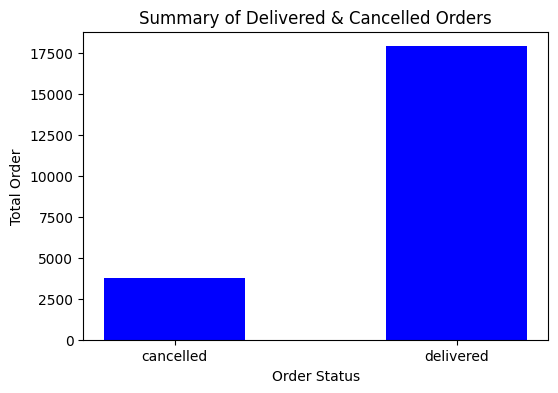

In [62]:
fig = plt.figure(figsize=(6, 4))
plt.bar(df_status_summary['order_status'], df_status_summary['order_cnt'],
        color='blue', width=0.5)
plt.xlabel('Order Status')
plt.ylabel('Total Order')
plt.title('Summary of Delivered & Cancelled Orders')
plt.show()

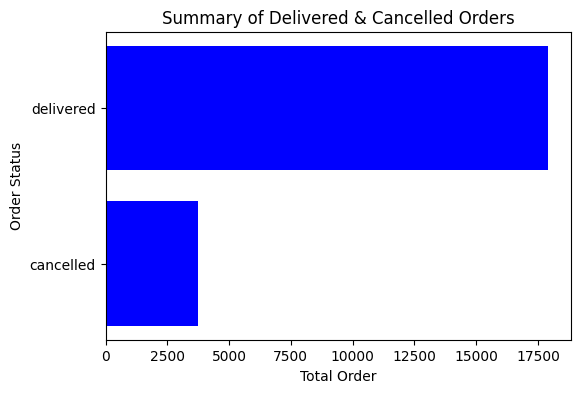

In [63]:
fig = plt.figure(figsize=(6, 4))
plt.barh(df_status_summary['order_status'], df_status_summary['order_cnt'],
         color='blue')
plt.xlabel('Total Order')
plt.ylabel('Order Status')
plt.title('Summary of Delivered & Cancelled Orders')
plt.show()

##5.3 Histogram

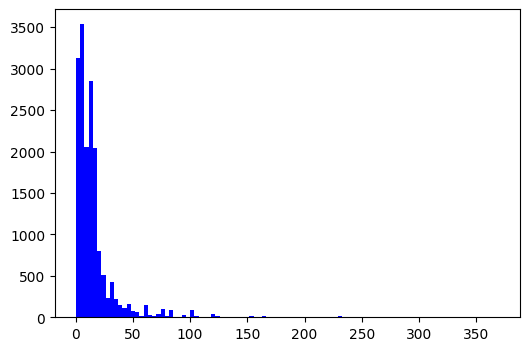

In [64]:
fig = plt.figure(figsize=(6, 4))
plt.hist(df_clean.loc[df_clean['product_name'].str.contains('tea'), 'amount'], 100,
         color='blue')
plt.show()

##5.4 Grafik garis (line chart)

In [65]:
df_date_summary = df_clean.groupby('date', as_index=False).agg(order_cnt=('order_id','nunique'))
df_date_summary

,date,order_cnt
0,2010-01-04,37
1,2010-01-05,37
2,2010-01-06,13
3,2010-01-07,72
4,2010-01-08,37
...,...,...
293,2010-12-19,23
294,2010-12-20,78
295,2010-12-21,57
296,2010-12-22,18


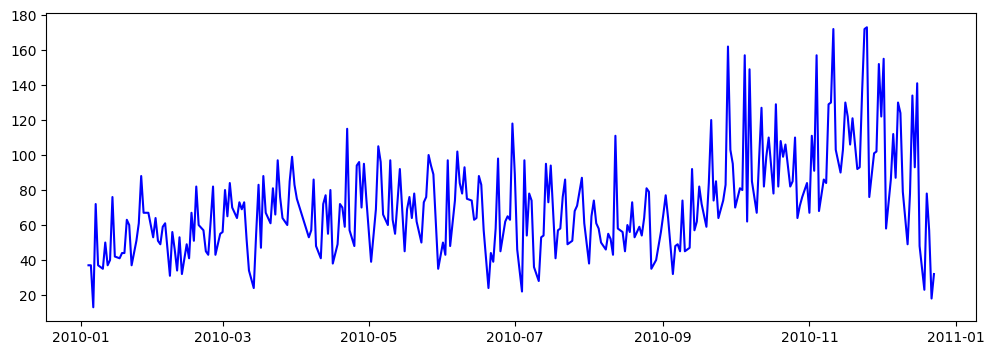

In [66]:
fig = plt.figure(figsize=(12, 4))
plt.plot('date', 'order_cnt', data=df_date_summary, color='blue', linestyle='-')
plt.show()

##5.5 Grafik lingkaran (pie chart)

In [67]:
df_status_summary

,order_status,order_cnt,total_amount
0,cancelled,3746,158184.030
1,delivered,17925,6932842.013


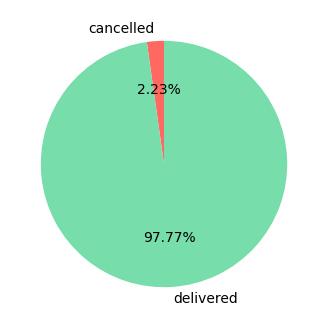

In [68]:
fig = plt.figure(figsize=(6, 4))
plt.pie(df_status_summary['total_amount'], labels=df_status_summary['order_status'],
        startangle=90, autopct='%1.2f%%', colors=['#FF6961','#77DDAA'])
plt.show()

##5.6 Grafik sebar (scatterplot)

In [69]:
df_tea_only = df_clean[df_clean['product_name'].str.contains('tea')]
df_tea_only

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
8,493414,21527,red retrospot traditional teapot,12,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,delivered,83.40
10,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,cancelled,23.85
20,493427,79000,moroccan tea glass,12,2010-01-04 10:43:00,0.85,13287.0,2010-01-04,delivered,10.20
56,C493430,21527,red retrospot traditional teapot,1,2010-01-04 11:43:00,7.95,14680.0,2010-01-04,cancelled,7.95
100,493432,22072,red retrospot tea cup and saucer,2,2010-01-04 12:30:00,3.75,14680.0,2010-01-04,delivered,7.50
...,...,...,...,...,...,...,...,...,...,...
455138,539958,22481,black tea towel classic design,3,2010-12-23 13:26:00,0.85,nan,2010-12-23,delivered,2.55
455196,539958,22900,set 2 tea towels i love london,1,2010-12-23 13:26:00,5.91,nan,2010-12-23,delivered,5.91
455467,539988,47559B,tea time oven glove,2,2010-12-23 16:06:00,1.25,18116.0,2010-12-23,delivered,2.50
455485,539991,22891,tea for one polkadot,1,2010-12-23 16:49:00,4.25,nan,2010-12-23,delivered,4.25


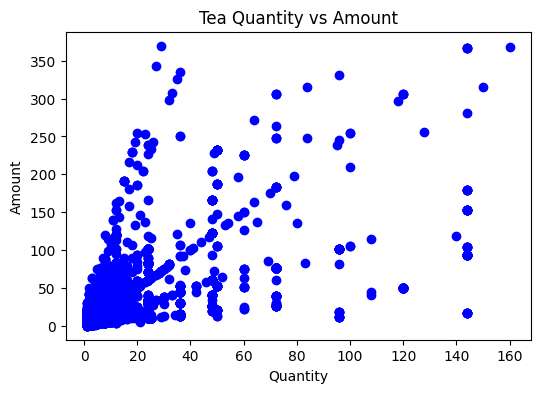

In [70]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(df_tea_only['quantity'], df_tea_only['amount'], c='blue', marker='o')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.title('Tea Quantity vs Amount')
plt.show()

##5.7 Grafik kotak-garis (boxplot)

In [71]:
df_tea_only

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
8,493414,21527,red retrospot traditional teapot,12,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,delivered,83.40
10,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,cancelled,23.85
20,493427,79000,moroccan tea glass,12,2010-01-04 10:43:00,0.85,13287.0,2010-01-04,delivered,10.20
56,C493430,21527,red retrospot traditional teapot,1,2010-01-04 11:43:00,7.95,14680.0,2010-01-04,cancelled,7.95
100,493432,22072,red retrospot tea cup and saucer,2,2010-01-04 12:30:00,3.75,14680.0,2010-01-04,delivered,7.50
...,...,...,...,...,...,...,...,...,...,...
455138,539958,22481,black tea towel classic design,3,2010-12-23 13:26:00,0.85,nan,2010-12-23,delivered,2.55
455196,539958,22900,set 2 tea towels i love london,1,2010-12-23 13:26:00,5.91,nan,2010-12-23,delivered,5.91
455467,539988,47559B,tea time oven glove,2,2010-12-23 16:06:00,1.25,18116.0,2010-12-23,delivered,2.50
455485,539991,22891,tea for one polkadot,1,2010-12-23 16:49:00,4.25,nan,2010-12-23,delivered,4.25


<Axes: ylabel='quantity'>

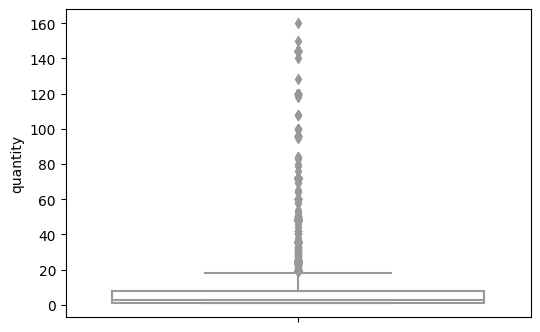

In [72]:
fig = plt.figure(figsize=(6, 4))
sns.boxplot(data=df_tea_only, y='quantity', color='white')

<Axes: ylabel='amount'>

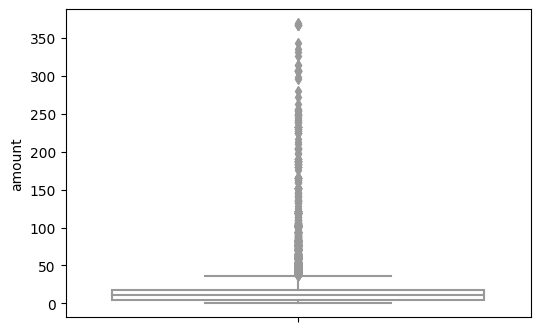

In [73]:
fig = plt.figure(figsize=(6, 4))
sns.boxplot(data=df_tea_only, y='amount', color='white')

##5.8 Heatmap - Correlation

<ipython-input-74-508d3246b6f5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_clean.corr(), cmap='Blues', annot=True)


<Axes: >

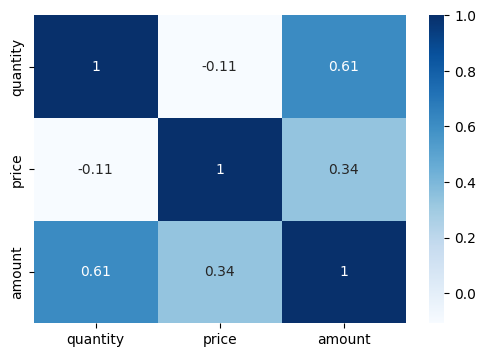

In [74]:
fig = plt.figure(figsize=(6, 4))
sns.heatmap(df_clean.corr(), cmap='Blues', annot=True)